In [ ]:
!pip install numpy
!pip install pandas==1.5.3
!pip install trueskill
!pip install matplotlib
!pip install scipy

In [18]:
!pip freeze > requirements.txt

# Installations

In [1]:
import random 
import importlib
from os import listdir
from os.path import isfile, join
import numpy as np
import copy
import pandas as pd
import trueskill as ts
from utils.animation import animation
import warnings
import sys

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

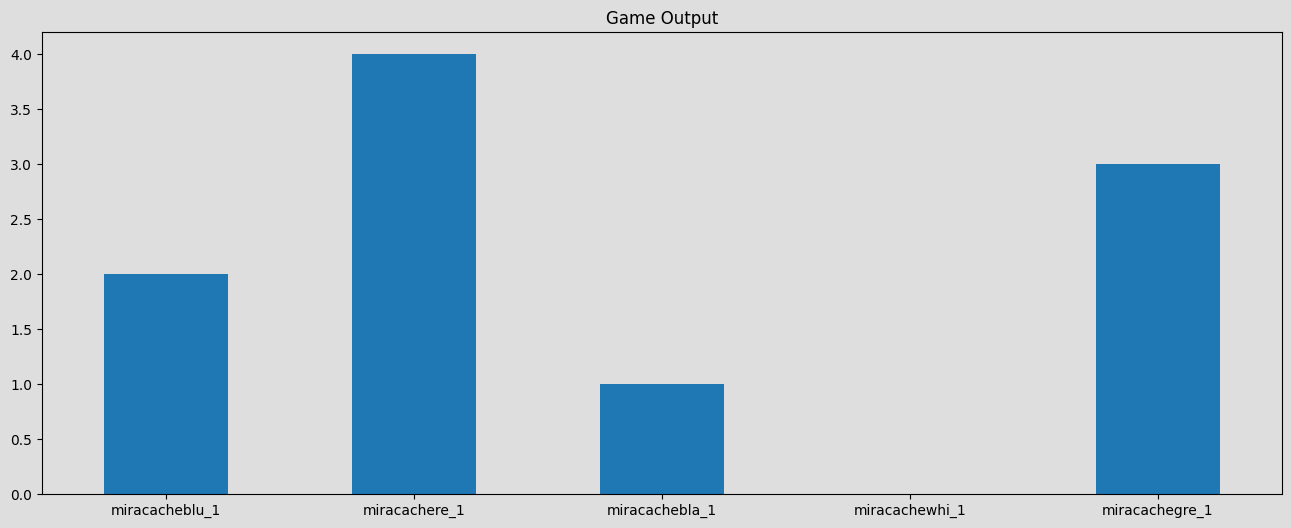

In [10]:
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:\\GITHUB\\1010-DIRTY-SANTA\\dirty-santa\\agents')
# environment variables

## path with all agents
AGENTS_PATH = 'C:\\GITHUB\\1010-DIRTY-SANTA\\dirty-santa\\'

## number of players and runs
N_PLAYERS = 5
RERUNS = 100

## aggregate data
runs = []
   
## select agents
all_agents = [f for f in listdir(join(AGENTS_PATH, 'agents\\')) if (isfile(join(AGENTS_PATH, 'agents\\', f))) & ('.py' in f)]

agents_history = pd.read_csv(join(AGENTS_PATH, 'data\\history.csv'), index_col=0)
missing_agents = [file for file in all_agents if file not in agents_history.filename.unique()]

for miss in missing_agents:
    new_df = pd.DataFrame([miss,miss.split('_')[0]
                               , miss.split('_')[1].split('.')[0]
                               , pd.to_datetime('today').date()
                               , 0, 1000,1000/3, 1]
                          , index = ['filename', 'user', 'version'
                                     , 'submission_date', 'games', 'miu', 'std', 'record_active']).T
    agents_history = agents_history.append(new_df,ignore_index=True)
agent_files = list(random.sample(set(agents_history.filename.unique()), N_PLAYERS))
agents = []
random.shuffle(agent_files)

## load agents
for agent in agent_files:
    agents.append(importlib.import_module(agent.replace('.py','') , package=None))

## set standings
player_df = pd.DataFrame(agents)
player_df['filename'] = agent_files
standings = pd.DataFrame(index=range(N_PLAYERS)).sort_index()


# begin run
for rerun in range(RERUNS):

    ## gifts
    private_gifts = list(range(N_PLAYERS))
    random.shuffle(private_gifts)

    ## players shuffled
    players = player_df.sample(frac=1).copy()
    agents = list(players[0].values)
    player_ids = list(players.index)

    ## initialize decision dictionar
    private_decisions = {}
    public_decisions = {}


    # iterate each round    
    for round in range(N_PLAYERS):

        ## round 1 has no decision
        if round == 0:
            ### private decisions 
            private_decisions[round] =dict()
            private_decisions[round]['decisions'] = copy.deepcopy({player_ids[round]:private_gifts[round]})
            private_decisions[round]['trade'] = list(copy.deepcopy(private_decisions[0]['decisions']).keys())[0]


            ### assign private gift to player for round 1
            private_decisions[round+1] = copy.deepcopy(private_decisions[round])
            private_decisions[round+1]['decisions'][player_ids[round+1]] = private_gifts[round+1]

            ### assign public gift to player for round 1
            values = []
            for key, value in private_decisions[round+1]['decisions'].items():
                values.append(value)
            public_gifts = list(np.argsort(np.argsort(values))) 
            for reverse_round in range(round+1,-1,-1):
                player_match = {}
                iteration = reverse_round
                for key, value in private_decisions[reverse_round]['decisions'].items():
                    player_match[key] = public_gifts[reverse_round - iteration]
                    iteration -= 1
                public_decisions[reverse_round] = {}
                public_decisions[reverse_round]['decisions'] = player_match        
                public_decisions[reverse_round]['trade'] = list( player_match.keys())[0]

        ## round >= 1    
        else: 

            ### re-generate public decision
            public_decisions = copy.deepcopy(private_decisions)

            #### get all private values
            values = []
            for key, value in private_decisions[round]['decisions'].items():
                values.append(value)

            #### get public values mapping    
            public_gifts = list(np.argsort(np.argsort(values))) 

            #### update values in the public decision
            for iterround in range(0, round+1):
                for key, value in public_decisions[iterround]['decisions'].items():
                    public_decisions[iterround]['decisions'][key] = public_gifts[values.index(value)]        

            # obtain agent decision
            public_decisions[round]['trade'] = '?'
            traded_with = agents[round].trade_with(runs.copy(), copy.deepcopy(public_decisions), standings)
            private_decisions[round]['trade'] = traded_with


            # update private decision with agent input
            if round == N_PLAYERS-1:
                old_value = private_decisions[round]['decisions'][traded_with]
                private_decisions[round]['decisions'][traded_with] = list(private_decisions[round]['decisions'].values())[-1]
                private_decisions[round]['decisions'][list(private_decisions[round]['decisions'].keys())[-1]] = old_value                    
            else:
                private_decisions[round+1] = copy.deepcopy(private_decisions[round])
                old_value = private_decisions[round]['decisions'][traded_with]
                private_decisions[round+1]['decisions'][traded_with] = list(private_decisions[round]['decisions'].values())[-1]
                private_decisions[round+1]['decisions'][list(private_decisions[round+1]['decisions'].keys())[-1]] = old_value
                private_decisions[round+1]['decisions'][player_ids[round+1]] = private_gifts[round+1]     
        
    runs.append(private_decisions)
    # update standings
    final_standing = private_decisions[list(private_decisions.keys())[-1]]['decisions']
    if rerun==0:
        standings = pd.DataFrame(final_standing, index=[0]).T.sort_index()
    else:
        standings = pd.concat([standings, pd.DataFrame(final_standing, index=[0]).T.rename(columns={0:rerun}).sort_index()], axis = 1)    


# calculate rating change and save
player_df['results'] = standings.sum(axis=1)
ranks = list(np.argsort(np.argsort(list(standings.sum(axis=1))))) 
ranks = [ len(ranks) - rank for rank in ranks]
player_df['rank'] = ranks
results = pd.merge(player_df, agents_history[agents_history['record_active']==1],on='filename', how='left')
ratings = []
ranks_sorted = []
for index, row in results.iterrows():
    ratings.append((ts.Rating(row['miu'], row['std']),))
    ranks_sorted.append(row['rank'])

agents_history.loc[agents_history[(agents_history['record_active']==1) & (agents_history['filename'].isin(results['filename'].values))].index,'record_active'] = 0

new_rates = ts.rate(ratings, ranks=ranks_sorted)
results['new_miu'] = [ratings[0].mu for ratings in new_rates]
results['new_std'] = [ratings[0].sigma for ratings in new_rates]
results['games']+=1    

agents_history = agents_history.append(results[['filename', 'user', 'version', 'submission_date', 'games', 'new_miu', 'new_std', 'record_active']].rename(columns={'new_miu':'miu','new_std':'std'}))
agents_history.reset_index(drop=True).to_csv(join(AGENTS_PATH, 'data\\history.csv'))    


game_id =  pd.read_csv(join(AGENTS_PATH, 'data\\results.csv') )['game_id'].max()+1
game_id = game_id if game_id == game_id else 1

results['game_id'] = game_id
results[['game_id', 'filename', 'results', 'rank', 'miu', 'std', 'new_miu', 'new_std']].to_csv(join(AGENTS_PATH, 'data\\results.csv') ,mode = 'a' , header=False ,index=False)

# create animation
animation(str(game_id), AGENTS_PATH, standings, player_df)        

In [20]:
pd.read_csv(join(AGENTS_PATH, 'data\\results.csv') )

,game_id,filename,results,rank,miu,std,new_miu,new_std
0,1,miracachewhi_1.py,55,5,1000.000000,333.333333,611.278397,222.234379
1,1,miracachebla_1.py,346,1,1000.000000,333.333333,1388.721603,222.234379
2,1,miracacheblu_1.py,175,4,1000.000000,333.333333,834.378243,186.018579
3,1,miracachere_1.py,213,2,1000.000000,333.333333,1165.621755,186.018578
4,1,miracachegre_1.py,211,3,1000.000000,333.333333,999.999999,178.605225
5,2,miracachere_1.py,206,2,1165.621755,186.018578,1187.907914,137.517106
6,2,miracachebla_1.py,343,1,1388.721603,222.234379,1472.934319,181.355629
7,2,miracachegre_1.py,195,4,999.999999,178.605225,845.007986,123.625381
8,2,miracacheblu_1.py,201,3,834.378243,186.018579,970.002217,121.223299
9,2,miracachewhi_1.py,55,5,611.278397,222.234379,541.645909,183.737463


In [21]:
pd.read_csv(join(AGENTS_PATH, 'data\\history.csv'), index_col='Unnamed: 0' )

,filename,user,version,submission_date,games,miu,std,record_active
0,miracachebla_1.py,miracachebla,1,2023-12-09,0,1000.000000,333.333333,0
1,miracacheblu_1.py,miracacheblu,1,2023-12-09,0,1000.000000,333.333333,0
2,miracachegre_1.py,miracachegre,1,2023-12-09,0,1000.000000,333.333333,0
3,miracachere_1.py,miracachere,1,2023-12-09,0,1000.000000,333.333333,0
4,miracachewhi_1.py,miracachewhi,1,2023-12-09,0,1000.000000,333.333333,0
5,miracachewhi_1.py,miracachewhi,1,2023-12-09,1,611.278397,222.234379,0
6,miracachebla_1.py,miracachebla,1,2023-12-09,1,1388.721603,222.234379,0
7,miracacheblu_1.py,miracacheblu,1,2023-12-09,1,834.378243,186.018579,0
8,miracachere_1.py,miracachere,1,2023-12-09,1,1165.621755,186.018578,0
9,miracachegre_1.py,miracachegre,1,2023-12-09,1,999.999999,178.605225,0


In [90]:
#grancopale_1 max
#grancopale_2 min
#grancopale_3 keeps
#grancopale_4 random
#grancopale_5 2nd best

# Sample Code

In [1]:
%%writefile "C:/Users/anton/SantaTrade/miracachebla_1.py"
import copy
import random
def trade_with(historical_results, picks_and_trades , overall_standings):
    """
    name your file with the first two or three letters of:
    - a color (e.g. [gr]een)
    - your first name (e.g. [an]tony)
    - your last name (e.g. [co]sta)
    - a sport (e.g. [pa]del)
    - your zodiac sign (e.g. [le]o)
    in any order you like
    and then "_" + version iterator
    """
    # get current distribution of gifts
    current_standing = picks_and_trades[list(picks_and_trades.keys())[-1]]['decisions']
    gifts = list(current_standing.values())
    
    ## get player who holds the best gift
    # best_gift = gifts.index(max(gifts))
    
    # get random gift
    best_gift = random.choice(gifts)
    
    # get users to trade with 
    trade = list(picks_and_trades[list(picks_and_trades.keys())[-1]]['decisions'].keys())[-1]  
    
    return trade

Overwriting C:/Users/anton/SantaTrade/grancopale_4.py


# Plot True Skill

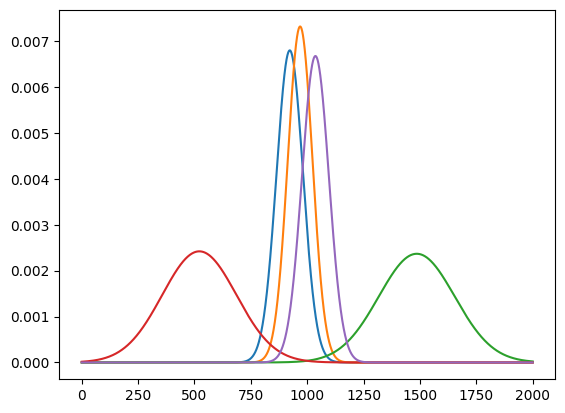

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
  
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 2000, 0.01)
  
for i in new_rates:
    plt.plot(x_axis, norm.pdf(x_axis, i[0].mu, i[0].sigma))
plt.show()

# Reset Environment

In [84]:
results[['game_id', 'filename', 'results', 'rank', 'miu', 'std', 'new_miu', 'new_std']].head(0).to_csv((join(AGENTS_PATH, 'data\\results.csv') ), index=False)

In [85]:
agents_history.head(0).to_csv(join(AGENTS_PATH, 'data\\history.csv'))